# Try guided autoencoder

In [1]:
import os
import colorcet as cc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR, LinearLR
from toolz import keyfilter, valmap
from torchmetrics.functional import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import warnings

from matplotlib import animation
from ipywidgets import Video
from aging.plotting import PlotConfig, format_pizza_plots, LONGTOGENY_AGE_CMAP
from itertools import product

In [2]:
format_pizza_plots()

In [3]:
warnings.simplefilter('ignore')

In [4]:
def zscore(ser):
    return (ser - ser.mean()) / ser.std()

In [5]:
def plot_embedding(cb: "PlottingCallback", index):
    emb = cb.points[index].T
    fig = plt.figure(figsize=(1.5, 1.5))
    ax = fig.gca()
    enc = LabelEncoder().fit_transform(cb.data.index.get_level_values("mouse"))
    mice = np.unique(enc)
    age = cb.data.index.get_level_values("pseudo_age").to_numpy()
    cmaps = {k: sns.blend_palette(["#333", cc.glasbey[k]], as_cmap=True) for k in mice}
    for k, v in cmaps.items():
        mask = enc == k
        ax.scatter(*emb[:, mask], c=age[mask], cmap=v, s=5, linewidths=0.05, edgecolors='silver', norm='log')
        # ax.scatter(*emb[:, mask], c=age[mask], cmap=v, s=4, norm="log")
    min_x, min_y = np.min(emb, axis=1)
    max_x, max_y = np.max(emb, axis=1)
    y_range = (max_y - min_y) * 0.02
    x_range = (max_x - min_x) * 0.02
    ax.set(
        xlim=(min_x - x_range, max_x + x_range),
        ylim=(min_y - y_range, max_y + x_range),
        xticks=[],
        yticks=[],
    )
    sns.despine(left=True, bottom=True)
    return fig

## Load longtogeny

In [6]:
version = 11
folder = Path(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}')

In [9]:
df = pd.read_parquet(folder / "longtogeny_males_relabeled_usage_matrix_v00.parquet")
df = df.sort_index(axis='columns')
# df.set_index('pseudo_age', append=True, inplace=True)

In [11]:
df.head()

0   \
age mouse subject_name session_name uuid                                 date                            
3.0 01_01 01_01_021    001          2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 2021-03-30 14:49:21  0.046524   
    01_02 01_02_021    001          181340b6-6c1d-4528-8920-2102d75d5711 2021-03-30 14:52:48  0.047799   
    01_03 01_03_021    001          b29c4d14-3e47-4ab9-8744-fb45862cc03c 2021-03-30 14:52:17  0.045718   
    01_04 01_04_021    001          b9459d2b-2357-427a-ad23-1b447a7621ea 2021-03-30 14:50:47  0.059656   
    02_02 02_02_021    001          567a1f13-cc44-478d-9547-bbe13f304592 2021-03-30 15:33:04  0.042155   

                                                                                                    1   \
age mouse subject_name session_name uuid                                 date                            
3.0 01_01 01_01_021    001          2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 2021-03-30 14:49:21  0.111963   
    01_02 01_02_021    001          181340b6-6c1d-4528-8920-2102d75d5711 2021-03-30 14:52:48  0.083294   
    01_03 01_03_021    001          b29c4d14-3e47-4ab9-8744-fb45862cc03c 2021-03-30 14:52:17  0.086806   
    01_04 01_04_021    001          b9459d2b-2357-427a-ad23-1b447a7621ea 2021-03-30 14:50:47  0.123001   
    02_02 02_02_021    001          567a1f13-cc44-478d-9547-bbe13f304592 2021-03-30 15:33:04  0.119438   

                                                                                                    2   \
age mouse subject_name session_name uuid                                 date                            
3.0 01_01 01_01_021    001          2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 2021-03-30 14:49:21  0.043967   
    01_02 01_02_021    001          181340b6-6c1d-4528-8920-2102d75d5711 2021-03-30 14:52:48  0.027449   
    01_03 01_03_021    001          b29c4d14-3e47-4ab9-8744-fb45862cc03c 2021-03-30 14:52:17  0.072338   
    01_04 01_04_021    001          b9459d2b-2357-427a-ad23-1b447a7621ea 2021-03-30 14:50:47  0.081796   
    02_02 02_02_021    001          567a1f13-cc44-478d-9547-bbe13f304592 2021-03-30 15:33:04  0.024590   

                                                                                                    3   \
age mouse subject_name session_name uuid                                 date                            
3.0 01_01 01_01_021    001          2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 2021-03-30 14:49:21  0.018405   
    01_02 01_02_021    001          181340b6-6c1d-4528-8920-2102d75d5711 2021-03-30 14:52:48  0.011358   
    01_03 01_03_021    001          b29c4d14-3e47-4ab9-8744-fb45862cc03c 2021-03-30 14:52:17  0.013310   
    01_04 01_04_021    001          b9459d2b-2357-427a-ad23-1b447a7621ea 2021-03-30 14:50:47  0.006150   
    02_02 02_02_021    001          567a1f13-cc44-478d-9547-bbe13f304592 2021-03-30 15:33:04  0.007611   

                                                                                                    4   \
age mouse subject_name session_name uuid                                 date                            
3.0 01_01 01_01_021    001          2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 2021-03-30 14:49:21  0.018405   
    01_02 01_02_021    001          181340b6-6c1d-4528-8920-2102d75d5711 2021-03-30 14:52:48  0.024610   
    01_03 01_03_021    001          b29c4d14-3e47-4ab9-8744-fb45862cc03c 2021-03-30 14:52:17  0.027199   
    01_04 01_04_021    001          b9459d2b-2357-427a-ad23-1b447a7621ea 2021-03-30 14:50:47  0.041820   
    02_02 02_02_021    001          567a1f13-cc44-478d-9547-bbe13f304592 2021-03-30 15:33:04  0.011710   

                                                                                                    5   \
age mouse subject_name session_name uuid                                 date                            
3.0 01_01 01_01_021    001          2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 2021-03-30 14:49:21  0.012781   
    01_02 01_02_021    001          181340b6-6c1d-4528-8920-2102d75

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

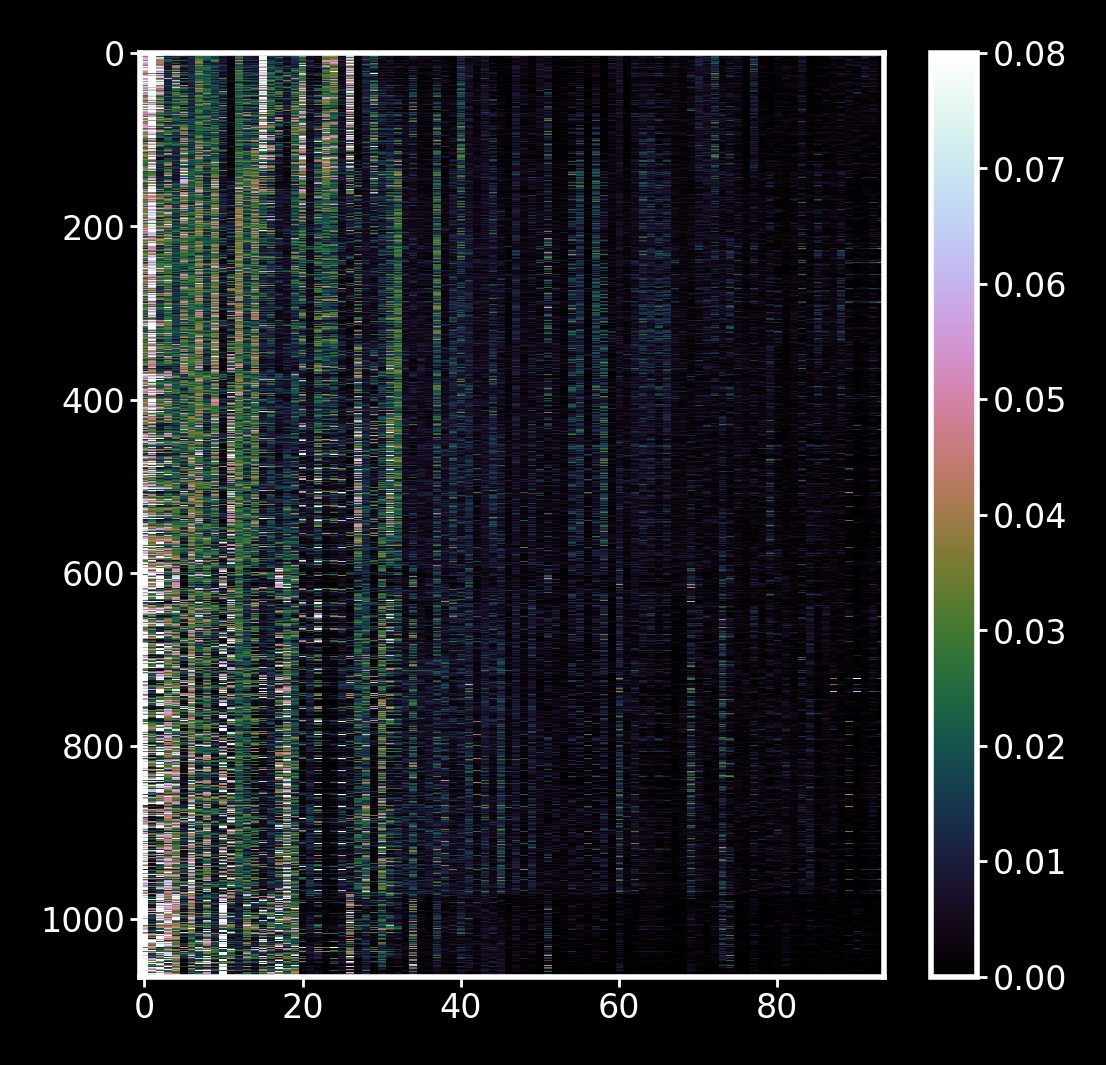

In [12]:
plt.imshow(df, aspect='auto', interpolation='none', vmax=0.08, cmap='cubehelix')
plt.colorbar()

In [13]:
class GuidedAE(nn.Module):
    def __init__(
        self,
        input_dims,
        activation,
        hidden_dims: list | tuple,
        latent_dim,
        mdl_type="regressor",
        n_classes=None,
    ):
        super().__init__()
        self.input_dims = input_dims
        self.n_layers = len(hidden_dims)
        self.hidden_dim = hidden_dims
        self.latent_dim = latent_dim
        if n_classes is None:
            n_classes = latent_dim

        layers = []
        for _in, _out in zip(hidden_dims, hidden_dims[1:]):
            layers.append(nn.Linear(_in, _out))
            layers.append(nn.BatchNorm1d(_out))
            layers.append(activation())

        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims[0]),
            activation(),
            *layers,
            nn.Linear(hidden_dims[-1], latent_dim),
            # activation(),
        )

        layers = []
        for _in, _out in zip(hidden_dims[::-1], hidden_dims[::-1][1:]):
            layers.append(nn.Linear(_in, _out))
            layers.append(nn.BatchNorm1d(_out))
            layers.append(activation())

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[-1]),
            activation(),
            *layers,
            nn.Linear(hidden_dims[0], input_dims),
        )
        # linear regressor to predict age
        if mdl_type == "regressor":
            self.lm = nn.Linear(latent_dim, 1)
        else:
            self.lm = nn.Linear(latent_dim, n_classes)

    def forward(self, x):
        latent = self.transform(x)
        return self.decoder(latent), self.lm(latent), latent

    def transform(self, x):
        return self.encoder(x)

    def predict(self, x):
        return self.lm(self.transform(x))

In [14]:
class AgeDataset(Dataset):
    def __init__(self, data: pd.DataFrame, log_xform: bool = False):
        self.age = data.index.get_level_values("age")
        self.syllables = data.to_numpy()
        if log_xform:
            self.syllables = np.log(self.syllables + 1e-6)

    def __len__(self):
        return len(self.age)

    def __getitem__(self, idx):
        return torch.tensor(self.syllables[idx], dtype=torch.float), torch.tensor(
            self.age[idx], dtype=torch.float
        )


class MouseDataset(Dataset):
    def __init__(self, data: pd.DataFrame, log_xform: bool = False):
        self.mouse = data.index.get_level_values("mouse")
        self.mouse = LabelEncoder().fit_transform(self.mouse)
        self.syllables = data.to_numpy()
        if log_xform:
            self.syllables = np.log(self.syllables + 1e-6)

    def __len__(self):
        return len(self.mouse)

    def __getitem__(self, idx):
        return torch.tensor(self.syllables[idx], dtype=torch.float), torch.tensor(
            self.mouse[idx], dtype=torch.long
        )

In [15]:
def lr_func(epoch):
    if epoch < 30:
        return 1
    if epoch < 300:
        return 0.5
    return 0.1

In [16]:
class LitGAE(pl.LightningModule):
    def __init__(
        self,
        model,
        beta,
        data,
        batch_size=32,
        mdl_type="regressor",
        alpha=1e-4,
        lr=1e-3,
    ):
        super().__init__()
        self.model = model
        self.beta = beta
        self.data = data
        self.batch_size = batch_size
        self.mdl_type = mdl_type
        self.alpha = alpha
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        syllables, age = batch
        syllables_hat, age_hat, latent = self.model(syllables)
        loss = self.beta * F.mse_loss(syllables_hat, syllables)
        if self.mdl_type == "classifier":
            loss += (1 - self.beta) * F.cross_entropy(
                age_hat, age
            ) + self.alpha * torch.mean(torch.linalg.norm(latent, dim=1))
        else:
            loss += (1 - self.beta) * F.mse_loss(age_hat.squeeze(), age)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        syllables, age = batch
        syllables_hat, age_hat, _ = self.model(syllables)
        loss = self.beta * F.mse_loss(syllables_hat, syllables)
        if self.mdl_type == "classifier":
            loss += (1 - self.beta) * F.cross_entropy(age_hat, age)
        else:
            loss += (1 - self.beta) * F.mse_loss(age_hat.squeeze(), age)
        self.log("val_loss", loss, prog_bar=True)
        if self.mdl_type == "classifier":
            self.log("acc", age_hat.argmax(dim=1).eq(age).float().mean(), prog_bar=True)
        else:
            self.log("r2", r2_score(age_hat, age.unsqueeze(1)), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-6)
        sched = LinearLR(opt, start_factor=1, end_factor=0.1, total_iters=400)
        return dict(optimizer=opt, lr_scheduler=sched)

    def setup(self, stage):
        kfold = StratifiedKFold(5)
        ex = self.data.sample(frac=1.0, random_state=0)
        bins = pd.qcut(ex.index.get_level_values("age"), 15, labels=False)
        for i, (train, test) in enumerate(kfold.split(ex, bins)):
            break
        # train_d = ex.iloc[train]
        train_d = ex
        test_d = ex.iloc[test]
        if self.mdl_type == "classifier":
            self.training_data = MouseDataset(train_d, log_xform=False)
            self.val_data = MouseDataset(test_d, log_xform=False)
        else:
            self.training_data = AgeDataset(train_d, log_xform=False)
            self.val_data = AgeDataset(test_d, log_xform=False)

    def train_dataloader(self):
        return DataLoader(
            self.training_data,
            batch_size=self.batch_size,
            num_workers=int(os.environ.get("SLURM_CPUS_PER_TASK", default=1)),
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            num_workers=int(os.environ.get("SLURM_CPUS_PER_TASK", default=1)),
            shuffle=False,
        )

In [17]:
class PlottingCallback(pl.Callback):
    def __init__(self, data, n_epochs=2):
        super().__init__()
        self.data = data
        self.points = []
        self.n_epochs = n_epochs

    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module):
        if trainer.current_epoch % self.n_epochs == 0:

            emb = (
                model.transform(torch.tensor(self.data.to_numpy(), dtype=torch.float32))
                .detach()
                .numpy()
            )
            self.points.append(emb)


class MetricsAgg(pl.Callback):

    def __init__(self):
        super().__init__()
        self.data = []

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module):
        d = keyfilter(lambda k: k in ['acc', 'train_loss'], trainer.callback_metrics)
        d = valmap(lambda d: d.item(), d)
        d['epoch'] = trainer.current_epoch
        self.data.append(d)

In [18]:
# in_df = np.log(df[df.index.get_level_values('age') < 750] + 1e-6)
in_df = df[df.index.get_level_values('age') < 90]
in_df = in_df.transform(zscore, axis=1)

# in_df.index = in_df.index.set_levels(
#     zscore(pd.Series(in_df.index.levels[0])), level="age"
# )
in_df = in_df.iloc[:, :40]

In [19]:
mdl_type = "classifier"
n_mice = in_df.index.get_level_values("mouse").nunique()

In [20]:
config = PlotConfig()

In [21]:
(config.save_path / "movies").mkdir(exist_ok=True)

## Fit specific dim size and seed

In [22]:
mdl_type = "classifier"
n_mice = in_df.index.get_level_values("mouse").nunique()

In [23]:
pl.seed_everything(3)
model = GuidedAE(
    len(in_df.columns),
    nn.GELU,
    [75],
    latent_dim=2,
    mdl_type=mdl_type,
    n_classes=n_mice,
)
gae = LitGAE(
    model, 0.5, in_df, batch_size=64, mdl_type=mdl_type, alpha=1e-3, lr=1e-2
)
cb = PlottingCallback(in_df, n_epochs=1)

trainer = pl.Trainer(
    max_epochs=600,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=False,
    precision="16-mixed" if torch.cuda.is_available() else "bf16-mixed",
    enable_checkpointing=False,
    enable_progress_bar=True,
    check_val_every_n_epoch=100,
    callbacks=[cb],
)
trainer.fit(gae)

[rank: 0] Seed set to 3
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 6.5 K 
-----------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=600` reached.


KeyError: 'Level pseudo_age not found'

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

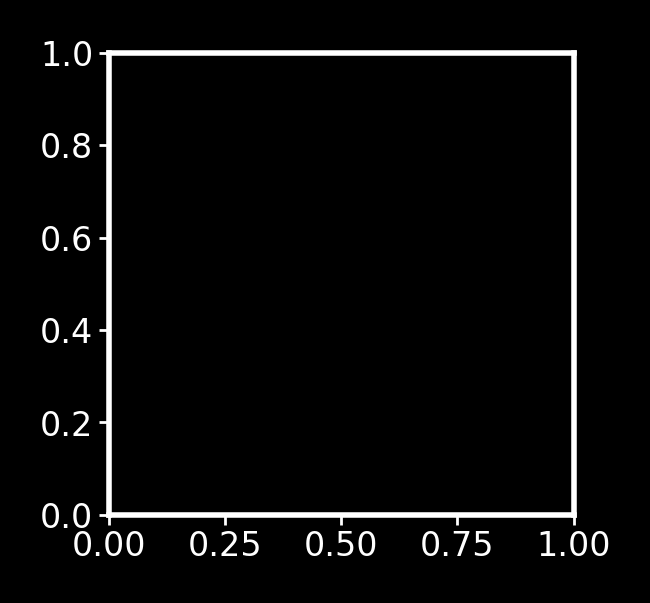

In [24]:
fig = plot_embedding(cb, -1)

In [ ]:
saver(fig, "guided-ae-embedding-bw");

In [ ]:
points = np.array(cb.points)

In [ ]:
points.shape

In [ ]:
x_points = pd.DataFrame(points[..., 0])
x_points = (
    x_points.rolling(window=7, center=True, win_type="gaussian").mean(std=1.5).dropna()
)

y_points = pd.DataFrame(points[..., 1])
y_points = (
    y_points.rolling(window=7, center=True, win_type="gaussian").mean(std=1.5).dropna()
)

In [ ]:
points = np.stack((x_points, y_points), axis=-1)

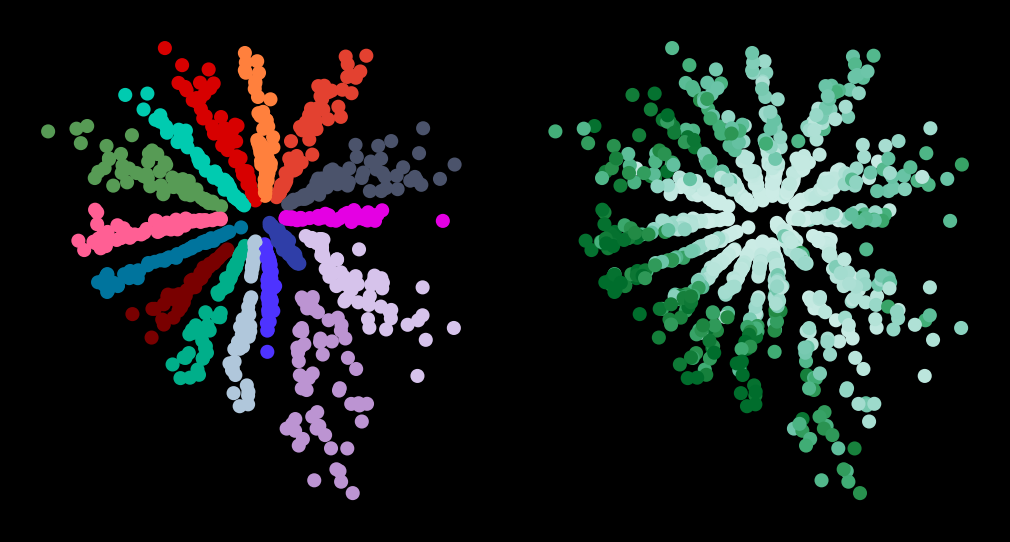

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
enc = LabelEncoder().fit_transform(cb.data.index.get_level_values("mouse"))
emb = points[0].T
scat1 = ax[0].scatter(*emb, c=enc, cmap=cc.cm.glasbey, s=3)
scat2 = ax[1].scatter(
    *emb, c=cb.data.index.get_level_values("pseudo_age"), s=3, cmap=LONGTOGENY_AGE_CMAP
)
min_x, min_y = np.min(emb, axis=1)
max_x, max_y = np.max(emb, axis=1)
y_range = (max_y - min_y) * 0.02
x_range = (max_x - min_x) * 0.02
for a in ax:
    a.set(
        xlim=(min_x - x_range, max_x + x_range),
        ylim=(min_y - y_range, max_y + x_range),
        xticks=[],
        yticks=[],
    )
sns.despine(left=True, bottom=True)


def update(frame):
    emb = frame.T
    min_x, min_y = np.min(emb, axis=1)
    max_x, max_y = np.max(emb, axis=1)
    y_range = (max_y - min_y) * 0.02
    x_range = (max_x - min_x) * 0.02
    scat1.set_offsets(emb.T)
    scat2.set_offsets(emb.T)
    for a in ax:
        a.set(
            xlim=(min_x - x_range, max_x + x_range),
            ylim=(min_y - y_range, max_y + x_range),
        )
    return scat1, scat2


ani = animation.FuncAnimation(
    fig=fig, func=update, frames=points, blit=True, interval=0
)
ani.save(
    filename=config.save_path / "movies" / "guided-ae-2plot-talk.mp4",
    writer="ffmpeg",
    fps=45,
)

In [88]:
Video.from_file(config.save_path / "movies" / "guided-ae-2plot-talk.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

In [28]:
misc = folder / "misc"
misc.mkdir(exist_ok=True)

In [29]:
torch.save(gae.model, misc / "guided_ae_params.pt")

In [30]:
import joblib

In [31]:
enc = LabelEncoder().fit_transform(cb.data.index.get_level_values("mouse"))
joblib.dump(
    dict(
        emb=cb.points[-1], age=cb.data.index.get_level_values("age"), mouse=enc
    ),
    misc / "embedding.p",
)

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11/misc/embedding.p']